In [1]:
import training
import numpy as np
import regularizers
import activations
import models
import topology
import utils
import plotting
import keras
import os
import tensorflow as tf
import modcog_gen

from regularizers import SpacialRegularizer
from keras import Regularizer
from typing import Callable
from sklearn.manifold import TSNE

np.random.seed(42)

/Users/huz/Documents/Repositories/dynamically-seRNNs/task.py:1813: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if rule is "testinit":


<h3>Training and evaluation loop for a model</h3>

In [2]:
local_stat_list = ["clustering", "clusters"]
global_stat_list = ["total_weight", "global_efficiency", "efficiency_per_weight", "small_worldness", "modularity", "total_weighted_edge_length", "corr_weight_distance",]

def evaluate_model(model_gen: Callable[[Regularizer], keras.Model], model_path: str, reg_strengths = list[float], regus: list[Regularizer] | None = None, train = None, test = None, stats: dict[str, list] | None = None, epochs:int = 10, steps:int = 40, learning_rate=0.001, load_from_file: bool = True, save_to_file: bool = True, local_stat_list: list[str] = [], global_stat_list: list[str] = [], accuracy_threshold: float = 0.8, verbose: bool = False, torch: bool = False) -> tuple[list[float], list[float], dict[str, float], dict[str, float]]:
    load_topologies = load_from_file
    if load_from_file:
        print(f"Trying to load history from {model_path}")
        try:
            histories = utils.load_history(model_path)
            if len(histories) != len(reg_strengths):
                raise ValueError(f"Number of histories ({len(histories)}) does not match number of regularizers ({len(reg_strengths)})")
            
            filtered_histories, filtered_reg_strengths = utils.threshold_history_by_accuracy(histories, reg_strengths, threshold=accuracy_threshold)
            print("History loaded successfully")
        except FileNotFoundError:
            print(f"File not found: {model_path}, loading from file failed.")
            load_from_file = False
            load_topologies = False
        except ValueError as e:
            print(f"Error loading history: {e}")
            load_from_file = False
            load_topologies = False

    if not load_from_file:
        print("Training new model")
        if train is None or test is None:
            raise ValueError("train and test datasets must be provided if load_from_file is False")
        if regus is None:
            raise ValueError("Regularizers must be provided if load_from_file is False")
        
        if torch:
            histories = training.train_torch(model_gen, regus, reg_strengths, train, test, epochs, steps, learning_rate)
        else:
            histories = training.train_keras(model_gen, regus, reg_strengths, train, test, epochs, steps, learning_rate)
        if save_to_file:
            training.save_histories(histories, model_path)
            print("Histories saved to file")

        filtered_histories, filtered_reg_strengths = utils.threshold_history_by_accuracy(histories, reg_strengths, threshold=accuracy_threshold)

        if save_to_file:
            training.save_models(filtered_reg_strengths, model_path)
            print("Filtered models saved to file")

    if load_topologies:
        print(f"Trying to load topologies from {model_path}")
        try:
            local_stats = utils.load_local_statistics(model_path)
            global_stats = utils.load_global_statistics(model_path)
            if list(local_stats.keys()) != local_stat_list:
                raise ValueError(f"Local statistics keys do not match: {local_stats.keys()} vs {local_stat_list}")
            if list(global_stats.keys()) != global_stat_list:
                raise ValueError(f"Global statistics keys do not match: {global_stats.keys()} vs {global_stat_list}")

            print("Topologies loaded successfully")
        except FileNotFoundError:
            print(f"File not found: {model_path}, loading from file failed.")
            load_topologies = False
        except ValueError as e:
            print(f"Error loading topologies: {e}")
            load_topologies = False
    
    if not load_topologies:
        print(f"Computing topologies. Local statistics: {local_stat_list}, Global statistics: {global_stat_list}")
        local_stats, global_stats = topology.compute_statistics(filtered_histories, local_stat_list, global_stat_list, verbose)
        print("Topologies computed successfully")
        if save_to_file:
            topology.save_statistics(local_stats, global_stats, model_path)
            print("Topologies saved to file")

    if stats is not None:
        stats["histories"].append(filtered_histories)
        stats["reg_strengths"].append(filtered_reg_strengths)
        stats["local_stats"].append(local_stats)
        stats["global_stats"].append(global_stats)
        
    return filtered_histories, filtered_reg_strengths, local_stats, global_stats
    

<h3>Functional and structural clustering visualisation</h3>

In [3]:
def get_clusters(vars):
    vars_filtered = activations.filter_inactive_nodes(vars, threshold=1e-3)
    vars_norm = activations.normalize_variances_across_nodes(vars_filtered)
    clusters, silhouette_scores, cluster_list, optimal_k = activations.calculate_optimal_clusters(vars_norm)
    return clusters, silhouette_scores, cluster_list, optimal_k, vars_norm

def plot_clusters(clusters, silhouette_scores, cluster_list, optimal_k, vars_norm, envs, range=False, model_dir=None):
    plotting.visualise_cluster_score(silhouette_scores, optimal_k, subdir=model_dir)
    labels, vars = activations.sort_clusters(clusters, vars_norm)
    if range:
        cluster_indices = [optimal_k-2, 3, 8, 13]
        labels_list = []
        variances = []
        names = []
        for ix in cluster_indices:
            cluster = cluster_list[ix]
            labels, vars = activations.sort_clusters(cluster, vars_norm)
            labels_list.append(labels)
            variances.append(vars)
            if ix == optimal_k-2:
                names.append(f"Optimal clusters ({optimal_k})")
                continue
            names.append(f"{ix+2} clusters")
        plotting.visualise_task_variances(labels_list, names, variances, envs, subdir=model_dir)
    else:
        plotting.visualise_task_variances([labels], [f"Optimal ({optimal_k}) clusters"], [vars], envs, subdir=model_dir)

In [3]:
import bct

def visualise_clustering(stats: dict[str, list]):
    tsne = TSNE(
            n_components=2,
            perplexity=30,
            learning_rate=200,
            random_state=42,
        )

    for var, reg_strs, lcl_stats, name, hists in zip(stats["variances"], stats["reg_strengths"], stats["local_stats"], stats["names"], stats["histories"]):
        norm_vars = activations.normalize_variances_across_nodes(var).T
        print(norm_vars.shape)
        tsne_results = tsne.fit_transform(norm_vars)

        net = len(reg_strs) // 2
        print(f"Visualising clustering for network {name} with regularization strength {reg_strs[net]}")
        if "clusters" not in lcl_stats.keys():
            print("Computing clusters")
            net = np.abs(hists[net]["weight_matrix"][-1])
            clusters, _ = bct.modularity_und(net)
            clusters = [clusters]
            print(f"Clusters found: {len(np.unique(clusters))}")
        else:
            print("Using precomputed clusters")
            clusters = lcl_stats["clusters"][net]
        print(f"Clusters: {clusters.shape}")
        print(f"TSNE results shape: {tsne_results.shape}")
        plotting.visualise_tsne(clusters, tsne_results, name)

Experiments involving the mazegen task from the seRNNs paper
======

In [4]:
path = "mazegen"
num_nets = 50
mazegen_stats = {"names": [], "histories": [], "reg_strengths": [], "local_stats": [], "global_stats": []}

Define model generator

In [5]:
def mazegen_model(regu: Regularizer) -> keras.Model:
    return keras.models.Sequential(
    [
        keras.layers.GaussianNoise(stddev=0.05),
        keras.layers.SimpleRNN(
            100,
            activation="relu",
            recurrent_initializer="orthogonal",
            return_sequences=False,
            recurrent_regularizer=regu,
        ),
        keras.layers.Dense(4, activation="softmax"),
    ]
)

Generate mazegen data

In [6]:
import mazegen

num_problems = 5120
batch_size = 128
num_batches = num_problems // batch_size

gen = mazegen.mazeGeneratorI(goal_presentation_steps=20,delay_steps=10,choices_presentation_steps=20)
train = gen.construct_tf_data(number_of_problems=num_problems, batch_size=batch_size)
test = gen.construct_tf_data(number_of_problems=num_problems//2, batch_size=batch_size)

batch = next(iter(train))
print(batch[0].shape, batch[1].shape)

(128, 50, 8) (128, 4)


<h3>Train 50 L1-Regularized RNNs with regularisation strengths between 10 and 250</h3>

Define regularization strength range

In [7]:
L1_path = os.path.join(path, "L1")

L1_reg_strengths = np.linspace(10, 250, num_nets)
L1_regus = [regularizers.L1(st) for st in L1_reg_strengths]
print("Strengths: ", L1_reg_strengths)

Strengths:  [ 10.          14.89795918  19.79591837  24.69387755  29.59183673
  34.48979592  39.3877551   44.28571429  49.18367347  54.08163265
  58.97959184  63.87755102  68.7755102   73.67346939  78.57142857
  83.46938776  88.36734694  93.26530612  98.16326531 103.06122449
 107.95918367 112.85714286 117.75510204 122.65306122 127.55102041
 132.44897959 137.34693878 142.24489796 147.14285714 152.04081633
 156.93877551 161.83673469 166.73469388 171.63265306 176.53061224
 181.42857143 186.32653061 191.2244898  196.12244898 201.02040816
 205.91836735 210.81632653 215.71428571 220.6122449  225.51020408
 230.40816327 235.30612245 240.20408163 245.10204082 250.        ]


Evaluate model

In [8]:
evaluate_model(mazegen_model, L1_path, L1_reg_strengths, L1_regus, train, test, mazegen_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
                                                    steps=num_batches, epochs=10, learning_rate=0.001, accuracy_threshold=0.9)
mazegen_stats["names"].append("L1")

Trying to load history from mazegen/L1
Retained 32 networks with final accuracy > 0.9 from 50
History loaded successfully
Trying to load topologies from mazegen/L1
Topologies loaded successfully


<h3>Train 50 seRNNs with regularisation strengths between 10 and 700</h3>

Define regularization strength range

In [9]:
seRNN_path = os.path.join(path, "seRNNs")

seRNN_reg_strengths = np.linspace(10, 700, num_nets)
seRNN_regus = [regularizers.SE1_sWc(st) for st in seRNN_reg_strengths]
print("Strengths: ", seRNN_reg_strengths)

Strengths:  [ 10.          24.08163265  38.16326531  52.24489796  66.32653061
  80.40816327  94.48979592 108.57142857 122.65306122 136.73469388
 150.81632653 164.89795918 178.97959184 193.06122449 207.14285714
 221.2244898  235.30612245 249.3877551  263.46938776 277.55102041
 291.63265306 305.71428571 319.79591837 333.87755102 347.95918367
 362.04081633 376.12244898 390.20408163 404.28571429 418.36734694
 432.44897959 446.53061224 460.6122449  474.69387755 488.7755102
 502.85714286 516.93877551 531.02040816 545.10204082 559.18367347
 573.26530612 587.34693878 601.42857143 615.51020408 629.59183673
 643.67346939 657.75510204 671.83673469 685.91836735 700.        ]


Evaluate model

In [10]:
evaluate_model(mazegen_model, seRNN_path, seRNN_reg_strengths, seRNN_regus, train, test, mazegen_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list,
               steps=num_batches, epochs=10, learning_rate=0.001, accuracy_threshold=0.9)
mazegen_stats["names"].append("seRNNs")

Trying to load history from mazegen/seRNNs
Retained 37 networks with final accuracy > 0.9 from 50
History loaded successfully
Trying to load topologies from mazegen/seRNNs
Topologies loaded successfully


<h3>Plot visualisations</h3>

In [ ]:
plotting.plot_all(path,
                  mazegen_stats["names"],
                  mazegen_stats["histories"],
                  mazegen_stats["local_stats"],
                  mazegen_stats["global_stats"])

plotting.generate_visualisations(path,
                                 mazegen_stats["names"], 
                                 mazegen_stats["histories"],
                                 mazegen_stats["reg_strengths"], 
                                 normalise=False,)

Visualising L1 with reg_strength 93.26531 from options [ 10.          14.89795918  24.69387755  29.59183673  34.48979592
  39.3877551   44.28571429  49.18367347  54.08163265  58.97959184
  63.87755102  68.7755102   73.67346939  78.57142857  83.46938776
  88.36734694  93.26530612  98.16326531 103.06122449 107.95918367
 122.65306122 127.55102041 132.44897959 137.34693878 142.24489796
 147.14285714 161.83673469 171.63265306 176.53061224 181.42857143
 191.2244898  240.20408163]
Visualising seRNNs with reg_strength 347.95918 from options [ 10.          24.08163265  38.16326531  52.24489796  66.32653061
  80.40816327  94.48979592 108.57142857 136.73469388 164.89795918
 178.97959184 193.06122449 235.30612245 249.3877551  263.46938776
 277.55102041 305.71428571 333.87755102 347.95918367 362.04081633
 376.12244898 404.28571429 432.44897959 446.53061224 460.6122449
 488.7755102  502.85714286 516.93877551 545.10204082 559.18367347
 601.42857143 615.51020408 629.59183673 643.67346939 657.75510204


Experiments involving the ModCog task suite from the LM-RNNs paper 
======

In [110]:
path = "modcog"

Generate ModCog data

In [111]:
num_batches = 150
batch_size = 64
seq_len = 50
envs = list(modcog_gen.original_envs.values()) + list(modcog_gen.seq_envs.values())

train = modcog_gen.ModCogDataset(batch_size=batch_size, seq_len=seq_len, num_batches=num_batches, envs=envs)
test = modcog_gen.ModCogDataset(batch_size=batch_size, seq_len=seq_len, num_batches=num_batches//4, train=False, envs=envs)

batch = next(iter(train.dataset))
print(batch[0].shape, batch[1].shape)

/Users/huz/.local/share/virtualenvs/dynamically-seRNNs-jOYgDnHA/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/Users/huz/.local/share/virtualenvs/dynamically-seRNNs-jOYgDnHA/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.ob to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ob` for environment variables or `env.get_wrapper_attr('ob')` that will search the reminding wrappers.
  logger.warn(
/Users/huz/.local/share/virtualenvs/dynamically-seRNNs-jOYgDnHA/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.gt to get variables from other wrappers is deprecated and will be removed in v1.0

(64, 50, 93) (64, 50)


Old way to calculate activations

In [112]:
def save_modcog_activations(model_gen: Callable[[Regularizer], keras.Model], model_path:str, batch: tuple, reg_strengths: list[float], regu: Callable, envs: list = modcog_gen.modcog_envs, load_from_file: bool = True, save_to_file: bool = True):
    try:
        mid = len(reg_strengths) // 2
        reg_strength = reg_strengths[mid]
    except TypeError:
        reg_strength = reg_strengths

    strength_str = utils.strength_to_str(reg_strength)
    activations_path = os.path.join(model_path, f"model_{strength_str}_activations.npy")

    if load_from_file:
        print(f"Trying to load activations from {activations_path}")
    try:
        acts = utils.load_activations(model_path, reg_strength)
        print("Activations loaded successfully")
        return acts
    except FileNotFoundError:
        print(f"File not found: {activations_path}, loading from file failed.")
        
    model = model_gen(regu(reg_strength))
    model.build(input_shape=batch[0].shape)

    print("Computing activations")
    acts = activations.calculate_modcog_activations(model, envs)

    if save_to_file:
        activations.save_activations(acts, model_path, reg_strength)
        print("Activations saved to file")

    return acts

Define model generator

In [113]:
neuron_per_dim = 8
neurons = neuron_per_dim**3 
network = (neuron_per_dim, neuron_per_dim, neuron_per_dim)
act_space = train.env.action_space.n
print(act_space)

def modcog_model(regu: Regularizer) -> keras.Model:
    return keras.models.Sequential(
    [
        keras.layers.GaussianNoise(stddev=0.05),
        keras.layers.SimpleRNN(
            neurons,
            activation="relu",
            recurrent_initializer="orthogonal",
            return_sequences=True,
            recurrent_regularizer=regu,
        ),
        keras.layers.Dense(act_space, activation="softmax"),
    ]
)

model = modcog_model(regularizers.L1(0))
model.build(input_shape=batch[0].shape)
print(model.summary())

17


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise_2                │ (64, 50, 93)           │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (64, 50, 512)          │       310,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (64, 50, 17)           │         8,721 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 318,993 (1.22 MB)

 Trainable params: 318,993 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

None


In [42]:
num_nets = 50
modcog_stats = {"names": [], "histories": [], "reg_strengths": [], "local_stats": [], "global_stats": []}

<h3>Train baseline models</h3>

No regularisation (optimal model)

In [43]:
training.train_keras(
    modcog_model,
    regus=[regularizers.L1(0)],
    reg_strengths=[0]*10,
    train_data=train.dataset,
    test_data=test.dataset,
    epochs=16,
    steps=num_batches,
    learning_rate=0.001
)

KeyboardInterrupt: 

Pool of autapses (very high regularisation)

In [ ]:
training.train_keras(
    modcog_model,
    regus=[regularizers.L1(0)],
    reg_strengths=[100000]*10,
    train_data=train.dataset,
    test_data=test.dataset,
    epochs=16,
    steps=num_batches,
    learning_rate=0.001
)

<h3>Train 50
 L1-Regularized RNNs with regularization strength between 10 and 125</h3>

Define regularization strength range and whether to load from file

In [44]:
L1_path = os.path.join(path, "L1")

L1_reg_strengths = np.linspace(10, 125, num_nets)
L1_regus = [regularizers.L1(st, se=regularizers.SpacialEmbedding(network_structure=network)) for st in L1_reg_strengths]
print("Strengths: ", L1_reg_strengths)

Strengths:  [ 10.          12.34693878  14.69387755  17.04081633  19.3877551
  21.73469388  24.08163265  26.42857143  28.7755102   31.12244898
  33.46938776  35.81632653  38.16326531  40.51020408  42.85714286
  45.20408163  47.55102041  49.89795918  52.24489796  54.59183673
  56.93877551  59.28571429  61.63265306  63.97959184  66.32653061
  68.67346939  71.02040816  73.36734694  75.71428571  78.06122449
  80.40816327  82.75510204  85.10204082  87.44897959  89.79591837
  92.14285714  94.48979592  96.83673469  99.18367347 101.53061224
 103.87755102 106.2244898  108.57142857 110.91836735 113.26530612
 115.6122449  117.95918367 120.30612245 122.65306122 125.        ]


Evaluate model

In [45]:
_, L1_filtered_reg_strengths, _, _ = evaluate_model(modcog_model, L1_path, L1_reg_strengths, L1_regus, train.dataset, test.dataset, modcog_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
                                                    steps=num_batches, epochs=16, learning_rate=0.001, accuracy_threshold=0.83, verbose=True)
modcog_stats["names"].append("L1")

Trying to load history from modcog/L1
Retained 32 networks with final accuracy > 0.83 from 50
History loaded successfully
Trying to load topologies from modcog/L1
Topologies loaded successfully


<h3>Train 50 seRNNs with regularization strength between 10 and 350</h3>

Define regularization strength range

In [46]:
seRNN_path = os.path.join(path, "seRNNs")

seRNN_reg_strengths = np.linspace(10, 350, num_nets)
seRNN_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(network_structure=network)) for st in seRNN_reg_strengths]
print("Strengths: ", seRNN_reg_strengths)

Strengths:  [ 10.          16.93877551  23.87755102  30.81632653  37.75510204
  44.69387755  51.63265306  58.57142857  65.51020408  72.44897959
  79.3877551   86.32653061  93.26530612 100.20408163 107.14285714
 114.08163265 121.02040816 127.95918367 134.89795918 141.83673469
 148.7755102  155.71428571 162.65306122 169.59183673 176.53061224
 183.46938776 190.40816327 197.34693878 204.28571429 211.2244898
 218.16326531 225.10204082 232.04081633 238.97959184 245.91836735
 252.85714286 259.79591837 266.73469388 273.67346939 280.6122449
 287.55102041 294.48979592 301.42857143 308.36734694 315.30612245
 322.24489796 329.18367347 336.12244898 343.06122449 350.        ]


Evaluate model

In [47]:
_, seRNNs_filtered_reg_strengths, _, _ = evaluate_model(modcog_model, seRNN_path, seRNN_reg_strengths, seRNN_regus, train.dataset, test.dataset, modcog_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_batches, epochs=16, learning_rate=0.001, accuracy_threshold=0.83)
modcog_stats["names"].append("seRNNs")

Trying to load history from modcog/seRNNs
Retained 25 networks with final accuracy > 0.83 from 50
History loaded successfully
Trying to load topologies from modcog/seRNNs
Topologies loaded successfully


<h3>Plot visualisations</h3>

In [48]:
cropped_modcog_stats = {"names": modcog_stats["names"], "histories": [], "reg_strengths": modcog_stats["reg_strengths"], "local_stats": [], "global_stats": []}
for hists in modcog_stats["histories"]:
    cropped_hists = []
    for hist in hists:
        cropped_hist = {}
        for key, val in hist.items():
            if key == "accuracy":
                cropped_hist["accuracy"] = val[:10]
            elif key == "loss":
                cropped_hist["loss"] = val[:10]
            elif key == "val_accuracy":
                cropped_hist["val_accuracy"] = val[:10]
            elif key == "val_loss":
                cropped_hist["val_loss"] = val[:10]

        cropped_hists.append(cropped_hist)
    cropped_modcog_stats["histories"].append(cropped_hists)


for lcl_stats in modcog_stats["local_stats"]:
    cropped_lcl_stats = {}
    for key, val in lcl_stats.items():
        if key == "clusters":
            cropped_lcl_stats["clusters"] = val[:, :10]
        elif key == "clustering":
            cropped_lcl_stats["clustering"] = val[:, :10]
    
    cropped_modcog_stats["local_stats"].append(cropped_lcl_stats)

        

for gbl_stats in modcog_stats["global_stats"]:
    cropped_gbl_stats = {}
    for key, val in gbl_stats.items():
        if key == "total_weight":
            cropped_gbl_stats["total_weight"] = val[:, :10]
        elif key == "global_efficiency":
            cropped_gbl_stats["global_efficiency"] = val[:, :10]
        elif key == "efficiency_per_weight":
            cropped_gbl_stats["efficiency_per_weight"] = val[:, :10]
        elif key == "small_worldness":
            cropped_gbl_stats["small_worldness"] = val[:, :10]
        elif key == "modularity":
            cropped_gbl_stats["modularity"] = val[:, :10]
        elif key == "total_weighted_edge_length":
            cropped_gbl_stats["total_weighted_edge_length"] = val[:, :10]
        elif key == "corr_weight_distance":
            cropped_gbl_stats["corr_weight_distance"] = val[:, :10]

In [49]:
plotting.plot_all(path,
                    [name+'-modcog' for name in modcog_stats["names"]] + [name+'-mazegen' for name in mazegen_stats["names"]],
                  cropped_modcog_stats["histories"] + mazegen_stats["histories"],
                  cropped_modcog_stats["local_stats"] + mazegen_stats["local_stats"],
                  cropped_modcog_stats["global_stats"] + mazegen_stats["global_stats"],)

In [50]:
plotting.generate_visualisations(path,
                                modcog_stats["names"], 
                                 modcog_stats["histories"],
                                 modcog_stats["reg_strengths"], normalise=False, proportion=0.5)

Visualising L1 with reg_strength 47.55102 from options [10.         12.34693878 14.69387755 17.04081633 19.3877551  21.73469388
 24.08163265 26.42857143 28.7755102  31.12244898 33.46938776 35.81632653
 38.16326531 40.51020408 42.85714286 45.20408163 47.55102041 49.89795918
 52.24489796 54.59183673 56.93877551 59.28571429 61.63265306 63.97959184
 66.32653061 68.67346939 71.02040816 73.36734694 78.06122449 87.44897959
 89.79591837 96.83673469]
Visualising seRNNs with reg_strength 93.26531 from options [ 10.          16.93877551  23.87755102  30.81632653  37.75510204
  44.69387755  51.63265306  58.57142857  65.51020408  72.44897959
  79.3877551   86.32653061  93.26530612 100.20408163 107.14285714
 114.08163265 121.02040816 127.95918367 134.89795918 155.71428571
 169.59183673 197.34693878 211.2244898  238.97959184 252.85714286]


<h2>Explorations of different spacial embeddings on seRNNs trained on ModCog</h2>

In [ ]:
path = "modcog/fixed_embeddings"

Define number of nets and topology metrics to calculate

In [ ]:
num_nets = 50
fixed_space_stats = {"names": [], "histories": [], "reg_strengths": [], "local_stats": [], "global_stats": []}

<h3>Randomly spaced neurons</h3>

In [ ]:
x = np.random.rand(neurons) * network[0]
y = np.random.rand(neurons) * network[1]
z = np.random.rand(neurons) * network[2]

# Combine the coordinates into a single array of shape (3, 245)
rand_coords = [x, y, z]
rand_coords = tf.constant(rand_coords, dtype=tf.float32)

Define regularization strength range

In [ ]:
rand_path = os.path.join(path, "random")

rand_reg_strengths = np.linspace(10, 350, num_nets)
rand_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(coordinates_list=rand_coords)) for st in rand_reg_strengths]
print("Strengths: ", rand_reg_strengths)

Strengths:  [ 10. 180. 350.]


Evaluate model

In [ ]:
_, rand_filtered_reg_strengths, _, _ = evaluate_model(modcog_model, rand_path, rand_reg_strengths, rand_regus, train.dataset, test.dataset, fixed_space_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_batches, epochs=16, accuracy_threshold=0.83)
fixed_space_stats["names"].append("random")

Trying to load history from modcog/fixed_embeddings/random
Retained 2 networks with final accuracy > 0.83 from 3
History loaded successfully
Trying to load topologies from modcog/fixed_embeddings/random
Topologies loaded successfully
Trying to load activations from modcog/fixed_embeddings/random/model_180.00000_activations.npy
Activations loaded successfully


<h3>Tube</h3>

Redefine model with new number of neurons

In [ ]:
tube_neurons = 525
tube_network = (21,5,5)

def tube_model(regu: Regularizer) -> keras.Model:
    return keras.models.Sequential(
    [
        keras.layers.GaussianNoise(stddev=0.05),
        keras.layers.SimpleRNN(
            tube_neurons,
            activation="relu",
            recurrent_initializer="orthogonal",
            return_sequences=True,
            recurrent_regularizer=regu,
        ),
        keras.layers.Dense(act_space, activation="softmax"),
    ]
)

Define regularization strength range

In [ ]:
tube_path = os.path.join(path, "tube")

tube_reg_strengths = np.linspace(10, 350, num_nets)
tube_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(network_structure= tube_network)) for st in tube_reg_strengths]
print("Strengths: ", tube_reg_strengths)

Strengths:  [ 10. 180. 350.]


Evaluate model

In [ ]:
_, tube_filtered_reg_strengths, _, _ = evaluate_model(tube_model, tube_path, tube_reg_strengths, tube_regus, train.dataset, test.dataset, fixed_space_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_batches, epochs=16, accuracy_threshold=0.83)
fixed_space_stats["names"].append("tube")

Trying to load history from modcog/fixed_embeddings/tube
Retained 2 networks with final accuracy > 0.83 from 3
History loaded successfully
Trying to load topologies from modcog/fixed_embeddings/tube
Topologies loaded successfully
Trying to load activations from modcog/fixed_embeddings/tube/model_180.00000_activations.npy
Activations loaded successfully


<h3>Hollow Sphere</h3>

Approximately even surface distribution

In [ ]:
radius = 2.0

phi = (np.sqrt(5.) - 1.0) / 2.0

i = np.arange(neurons)
z = radius * (1 - 2 * i / (neurons - 1))

theta = np.arccos(z / radius)

phi_golden = 2 * np.pi * (i * phi % 1)

x = radius * np.sin(theta) * np.cos(phi_golden)
y = radius * np.sin(theta) * np.sin(phi_golden)

sphere_coords = [x, y, z]
sphere_coords = tf.constant(sphere_coords, dtype=tf.float32)

Define regularization strength range

In [ ]:
sphere_path = os.path.join(path, "sphere")

sphere_reg_strengths = np.linspace(10, 350, num_nets)
sphere_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(coordinates_list=sphere_coords)) for st in sphere_reg_strengths]
print("Strengths: ", sphere_reg_strengths)

Strengths:  [ 10. 180. 350.]


Evaluate model

In [ ]:
_, sphere_filtered_reg_strengths, _, _ = evaluate_model(modcog_model, sphere_path, sphere_reg_strengths, sphere_regus, train.dataset, test.dataset, fixed_space_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_batches, epochs=16, accuracy_threshold=0.83)
fixed_space_stats["names"].append("sphere")

Trying to load history from modcog/fixed_embeddings/sphere
File not found: modcog/fixed_embeddings/sphere, loading from file failed.
Training new model
Loss function: sparse_categorical_crossentropy
Regularization strength: 10.00000
Epoch 1/16
150/150 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.7126 - loss: 3.7382 - val_accuracy: 0.7417 - val_loss: 1.4775
Epoch 2/16
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7407 - loss: 1.4193 - val_accuracy: 0.7425 - val_loss: 1.2841
Epoch 3/16
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7453 - loss: 1.2637 - val_accuracy: 0.7515 - val_loss: 1.1973
Epoch 4/16
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7527 - loss: 1.1743 - val_accuracy: 0.7652 - val_loss: 1.0901
Epoch 5/16
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.7699 - loss: 1.0541 - val_accuracy: 0.7847 - val_loss: 0.9522
Epoch 6/16
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.7877 - loss: 0.9367 - val_accuracy: 0.8072 - val_loss:

<h3>Plot visualisations</h3>

Visualising sphere with reg_strength 180.00000 from options [ 10. 180.]


/Users/huz/Documents/Repositories/dynamically-seRNNs/plotting.py:223: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


KeyboardInterrupt: 

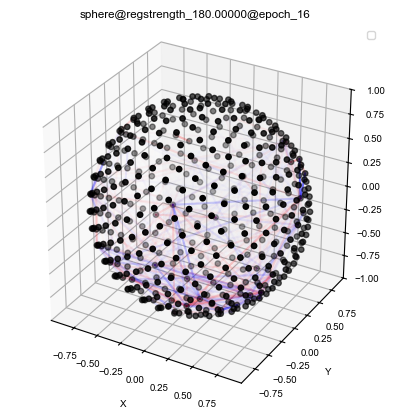

In [ ]:
plotting.generate_visualisations(path, 
                                 fixed_space_stats["names"], 
                                 fixed_space_stats["histories"],
                                 fixed_space_stats["reg_strengths"],
                                 normalise=False, proportion=0.1)

plotting.plot_all(path,
                  fixed_space_stats["names"] + modcog_stats["names"],
                  fixed_space_stats["histories"] + modcog_stats["histories"],
                  fixed_space_stats["local_stats"] + modcog_stats["local_stats"],
                  fixed_space_stats["global_stats"] + modcog_stats["global_stats"])

<h2>Experiments involving dynamically spacially embedded RNNs</h2>

In [114]:
path = "modcog/dynamic_embeddings"
learning_rate = 0.01

<h3>Train SE1 regularized dynamic models with regularization strengths between 10 and 350</h3>

Define model generator and number of nets

In [115]:
def dynamic_model(regu: SpacialRegularizer) -> keras.Model:
    return keras.models.Sequential(
    [
        keras.layers.GaussianNoise(stddev=0.05),
        models.KerasDynamicSpacialRNN(
            neurons,
            recurrent_regularizer=regu,
            activation="relu",
            recurrent_initializer="orthogonal",
            return_sequences=True,
            coord_initializer=keras.initializers.RandomUniform(minval=-0, maxval=8, seed=42)
        ),
        keras.layers.Dense(act_space, activation="softmax"),
    ]
)

Define regularization strengths ranges

In [118]:
se1_path = os.path.join(path, f"SE1@learning_rate={learning_rate}")
num_nets = 10

se1_reg_strengths = np.linspace(10, 350, num_nets)
se1_regus = [regularizers.SE1(st) for st in se1_reg_strengths]
print("Strengths: ", se1_reg_strengths)

Strengths:  [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


Evaluate model

In [120]:
se1_histories, se1_filtered_reg_strengths, se1_local_stats, se1_global_stats = evaluate_model(dynamic_model, se1_path, se1_reg_strengths, se1_regus, train.dataset, test.dataset, 
                                        steps=num_batches, learning_rate=learning_rate, epochs=16, accuracy_threshold=0.83)

Trying to load history from modcog/dynamic_embeddings/SE1@learning_rate=0.01
Retained 9 networks with final accuracy > 0.83 from 10
History loaded successfully
Trying to load topologies from modcog/dynamic_embeddings/SE1@learning_rate=0.01
Error loading topologies: Local statistics keys do not match: dict_keys(['clustering', 'communicability', 'clusters']) vs []
Computing topologies. Local statistics: [], Global statistics: []
Network 1/9
Network 2/9
Network 3/9
Network 4/9
Network 5/9
Network 6/9
Network 7/9
Network 8/9
Network 9/9
Topologies computed successfully
Topologies saved to file


Visualise

In [121]:
names = ["dp_1.0"] * len(se1_filtered_reg_strengths)
reg_strs = [[st] for st in se1_filtered_reg_strengths]
hists = [[hist] for hist in se1_histories]
plotting.generate_visualisations(os.path.join(se1_path, "normalise"),
                                    names,
                                    hists,
                                    reg_strs,
                                    normalise=True, proportion=0.1)


Visualising dp_1.0 with reg_strength 47.77778 from options [47.77777777777778]
Visualising dp_1.0 with reg_strength 85.55556 from options [85.55555555555556]
Visualising dp_1.0 with reg_strength 123.33333 from options [123.33333333333334]
Visualising dp_1.0 with reg_strength 161.11111 from options [161.11111111111111]
Visualising dp_1.0 with reg_strength 198.88889 from options [198.88888888888889]
Visualising dp_1.0 with reg_strength 236.66667 from options [236.66666666666669]
Visualising dp_1.0 with reg_strength 274.44444 from options [274.44444444444446]
Visualising dp_1.0 with reg_strength 312.22222 from options [312.22222222222223]
Visualising dp_1.0 with reg_strength 350.00000 from options [350.0]


Plot all stats

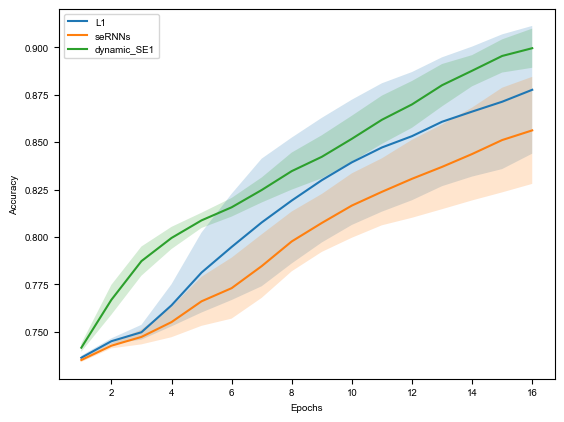

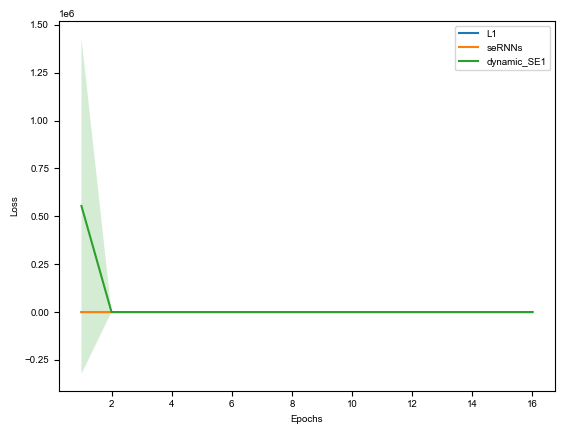

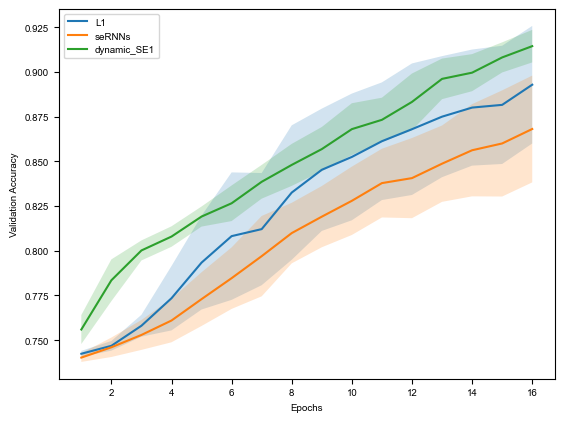

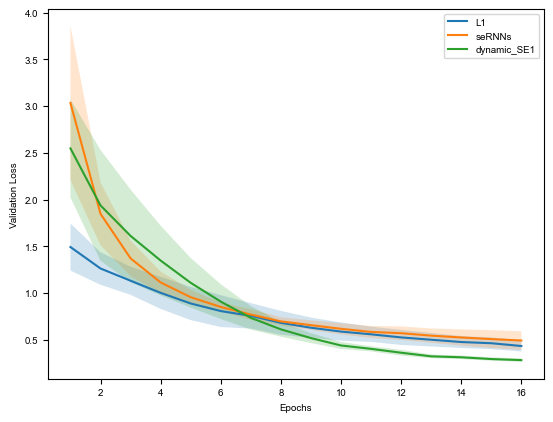

In [ ]:
plotting.plot_all(se1_path,
                  modcog_stats["names"] + ["dynamic_SE1"],
                    modcog_stats["histories"] + [se1_histories],
                    modcog_stats["local_stats"] + [se1_local_stats],
                    modcog_stats["global_stats"] + [se1_global_stats])

<h3>Train SE1 regularized dynamic models with a repulsion factor for close neurons to prevent spatial collapse</h3>

Define dynamic model with a larger initialisation space

In [ ]:
def expanded_dynamic_model(regu: SpacialRegularizer) -> keras.Model:
    return keras.models.Sequential(
    [
        keras.layers.GaussianNoise(stddev=0.05),
        models.KerasDynamicSpacialRNN(
            neurons,
            recurrent_regularizer=regu,
            activation="relu",
            recurrent_initializer="orthogonal",
            return_sequences=True,
            coord_initializer=keras.initializers.RandomUniform(minval=-10, maxval=10, seed=42),
        ),
        keras.layers.Dense(act_space, activation="softmax"),
    ]
)

Define regularization strengths ranges

In [ ]:
repulsion_path = os.path.join(path, f"repulsion@learning_rate={learning_rate}")
num_reg_strengths = 4
num_repulsion_distances = 5

repulsion_reg_strengths = np.linspace(10, 350, num_reg_strengths)
repulsion_distances = np.linspace(0, 2, num_repulsion_distances)
repulsion_strengths = [(st, dist) for st in repulsion_reg_strengths for dist in repulsion_distances]
repulsion_regus = [regularizers.SE1_repulsion(st, repulsion_distance=dist) for st, dist in repulsion_strengths]
print("Strengths: ", repulsion_strengths)

Strengths:  [(10.0, 0.0), (10.0, 0.5), (10.0, 1.0), (10.0, 1.5), (10.0, 2.0), (123.33333333333333, 0.0), (123.33333333333333, 0.5), (123.33333333333333, 1.0), (123.33333333333333, 1.5), (123.33333333333333, 2.0), (236.66666666666666, 0.0), (236.66666666666666, 0.5), (236.66666666666666, 1.0), (236.66666666666666, 1.5), (236.66666666666666, 2.0), (350.0, 0.0), (350.0, 0.5), (350.0, 1.0), (350.0, 1.5), (350.0, 2.0)]


Evaluate model

In [ ]:
repulsion_histories, repulsion_filtered_reg_strengths, repulsion_local_stats, repulsion_global_stats = evaluate_model(expanded_dynamic_model, repulsion_path, repulsion_strengths, repulsion_regus, train.dataset, test.dataset, dynamic_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
                                                steps=num_batches, learning_rate=learning_rate, epochs=16, accuracy_threshold=0.83)

Trying to load history from modcog/dynamic_embeddings/repulsion@learning_rate=0.01
Retained 18 networks with final accuracy > 0.83 from 20
History loaded successfully
Trying to load topologies from modcog/dynamic_embeddings/repulsion@learning_rate=0.01
Topologies loaded successfully
Trying to load activations from modcog/dynamic_embeddings/repulsion@learning_rate=0.01/model_[236.66666667   0.        ]_activations.npy
Activations loaded successfully


Visualise

In [ ]:
names = ["rep_dist_{}".format(st[1]) for st in repulsion_filtered_reg_strengths]
reg_strs = [[st[0]] for st in repulsion_filtered_reg_strengths]
hists = [[hist] for hist in repulsion_histories]
plotting.generate_visualisations(repulsion_path,
                                    names,
                                    hists,
                                    reg_strs,
                                    normalise=False, proportion=0.1)

Visualising rep_dist_0.0 with reg_strength 10.00000 from options [10.0]


/Users/huz/Documents/Repositories/dynamically-seRNNs/plotting.py:223: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Visualising rep_dist_0.5 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_1.0 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_1.5 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_2.0 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_0.0 with reg_strength 123.33333 from options [123.33333333333333]
Visualising rep_dist_0.5 with reg_strength 123.33333 from options [123.33333333333333]


/Users/huz/Documents/Repositories/dynamically-seRNNs/plotting.py:227: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"plots/visualisations/{name}/{epoch_str}.png")


Visualising rep_dist_1.0 with reg_strength 123.33333 from options [123.33333333333333]
Visualising rep_dist_2.0 with reg_strength 123.33333 from options [123.33333333333333]
Visualising rep_dist_0.0 with reg_strength 236.66667 from options [236.66666666666666]
Visualising rep_dist_0.5 with reg_strength 236.66667 from options [236.66666666666666]
Visualising rep_dist_1.0 with reg_strength 236.66667 from options [236.66666666666666]
Visualising rep_dist_1.5 with reg_strength 236.66667 from options [236.66666666666666]
Visualising rep_dist_2.0 with reg_strength 236.66667 from options [236.66666666666666]
Visualising rep_dist_0.0 with reg_strength 350.00000 from options [350.0]
Visualising rep_dist_0.5 with reg_strength 350.00000 from options [350.0]
Visualising rep_dist_1.0 with reg_strength 350.00000 from options [350.0]
Visualising rep_dist_2.0 with reg_strength 350.00000 from options [350.0]


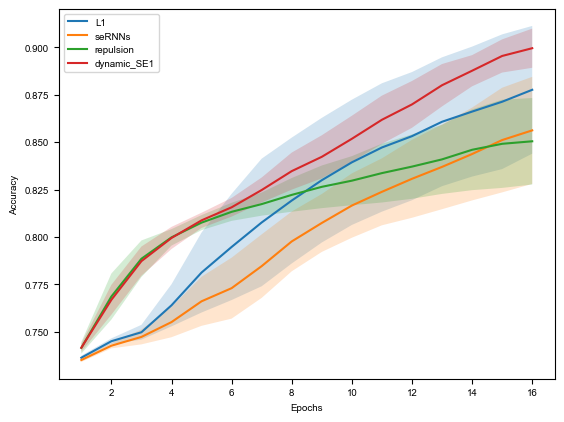

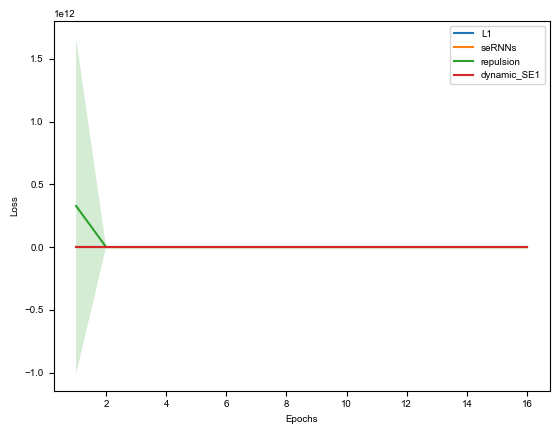

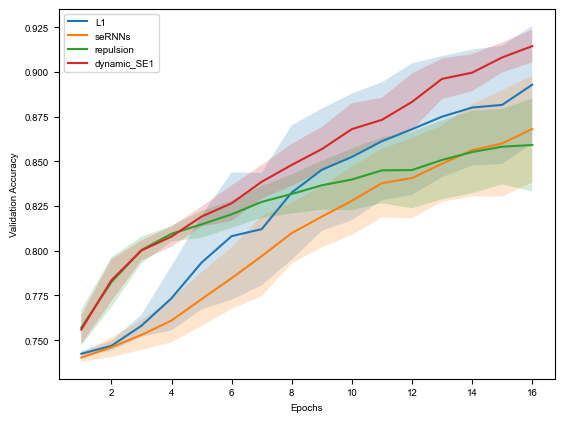

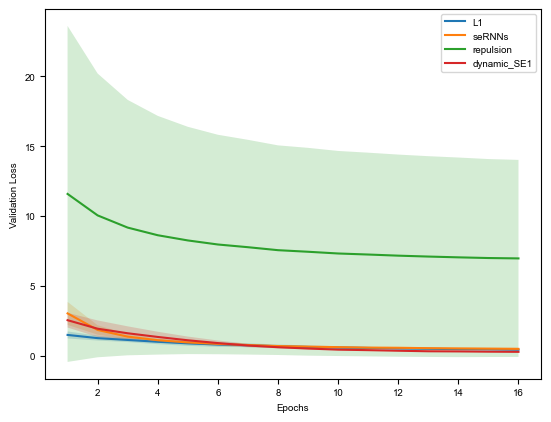

In [ ]:
plotting.plot_all(repulsion_path,
                  modcog_stats["names"] + ["repulsion"] + ["dynamic_SE1"],
                    modcog_stats["histories"] + [repulsion_histories] + [se1_histories],
                    modcog_stats["local_stats"] + [repulsion_local_stats] + [se1_local_stats],
                    modcog_stats["global_stats"] + [repulsion_global_stats] + [se1_global_stats])

Experiments involving the 20 task suite from Yang G paper
======

In [86]:
path = "task20"
num_nets = 10
task20_stats = {"names": [], "histories": [], "reg_strengths": [], "local_stats": [], "global_stats": []}

Generate 20 Task data

In [87]:
import task
import train_20_task

num_steps = 500
def data_gen(hp, rules = None, probs = None):
    if rules is None:
        rules = hp["rules"]
        probs = hp["rule_probs"]
    elif probs is None:
        probs = [1 / len(rules)] * len(rules)
    while True:
        task_choice = hp["rng"].choice(rules, p=probs)
        trial = task.generate_trials(task_choice, hp, "random", batch_size=hp["batch_size_train"])
        yield trial.x, trial.y

def dataloader_gen(hp, rules=None, probs=None, train=True):
    dataset = tf.data.Dataset.from_generator(
    lambda: data_gen(hp, rules, probs),
    output_signature=(
        tf.TensorSpec(shape=(None, hp["batch_size_train"], hp["n_input"]), dtype=tf.float32),
        tf.TensorSpec(shape=(None, hp["batch_size_train"], hp["n_output"]), dtype=tf.float32),
    ),
    ).prefetch(tf.data.AUTOTUNE)
    if train:
        return dataset.cache()
    else:
        return dataset

Define model params

In [88]:
network = (7,6,6)
neurons = network[0] * network[1] * network[2]
print(f"Network shape: {network}, Neurons: {neurons}")

hp = {
    "n_rnn": neurons,
    "activation": "softplus",
    "loss_type": "softmax",
}

Network shape: (7, 6, 6), Neurons: 252


<h3>Train 10
 L1-Regularized RNNs with regularization strength between 10 and 125</h3>

Define regularization strength range

In [89]:
L1_path = os.path.join(path, "L1")

L1_reg_strengths = np.linspace(10, 125, num_nets)
L1_regus = [regularizers.L1(st, se=regularizers.SpacialEmbedding(network_structure=network)) for st in L1_reg_strengths]
print("Strengths: ", L1_reg_strengths)

Strengths:  [ 10.          22.77777778  35.55555556  48.33333333  61.11111111
  73.88888889  86.66666667  99.44444444 112.22222222 125.        ]


Define model and dataset

In [90]:
L1_model, L1_hp = train_20_task.init_new_model(L1_path, hp)
L1_dataset = dataloader_gen(L1_hp, train=True)
L1_test_dataset = dataloader_gen(L1_hp, train=False)

batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = LeakyRNN
loss_type            = softmax
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
p_weight_train       = None
target_perf          = 1.0
n_eachring           = 16
num_ring             = 2
n_rule               = 20
rule_start           = 33
n_input              = 53
n_output             = 17
n_rnn                = 252
ruleset              = all
save_name            = test
learning_rate        = 0.001
c_intsyn             = 0
ksi_intsyn           = 0
seed                 = 42
rng                  = RandomState(MT19937)
rule_trains          = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multid

Evaluate model

In [91]:
_, L1_filtered_reg_strengths, _, _ = evaluate_model(L1_model, L1_path, L1_reg_strengths, L1_regus, L1_dataset, L1_test_dataset, task20_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
                                                    steps=num_steps, epochs=16, learning_rate=0.001, accuracy_threshold=0.8, verbose=True)
task20_stats["names"].append("L1")

Trying to load history from task20/L1
Retained 8 networks with final accuracy > 0.8 from 10
History loaded successfully
Trying to load topologies from task20/L1
Topologies loaded successfully


<h3>Train 10
 seRNNs with regularization strength between 10 and 350</h3>

Define regularization strength range and whether to load from file

Evaluate model

In [92]:
seRNN_path = os.path.join(path, "seRNNs")

seRNN_reg_strengths = np.linspace(10, 350, num_nets)
seRNN_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(network_structure=network)) for st in seRNN_reg_strengths]
print("Strengths: ", seRNN_reg_strengths)

Strengths:  [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


Define model and dataset

In [93]:
seRNN_model, seRNN_hp = train_20_task.init_new_model(seRNN_path, hp)
seRNN_train = dataloader_gen(seRNN_hp, train=True)
seRNN_test = dataloader_gen(seRNN_hp, train=False)

batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = LeakyRNN
loss_type            = softmax
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
p_weight_train       = None
target_perf          = 1.0
n_eachring           = 16
num_ring             = 2
n_rule               = 20
rule_start           = 33
n_input              = 53
n_output             = 17
n_rnn                = 252
ruleset              = all
save_name            = test
learning_rate        = 0.001
c_intsyn             = 0
ksi_intsyn           = 0
seed                 = 42
rng                  = RandomState(MT19937)
rule_trains          = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multid

Evaluate model

In [94]:
_, seRNNs_filtered_reg_strengths, _, _ = evaluate_model(seRNN_model, seRNN_path, seRNN_reg_strengths, seRNN_regus, seRNN_train, seRNN_test, task20_stats, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_steps, epochs=16, learning_rate=0.001, accuracy_threshold=0.8)
task20_stats["names"].append("seRNNs")

Trying to load history from task20/seRNNs
Retained 10 networks with final accuracy > 0.8 from 10
History loaded successfully
Trying to load topologies from task20/seRNNs
Topologies loaded successfully


<h3>Plot and visualise</h3>

Plot against modcog

In [60]:
plotting.plot_all(path,
                    ["L1-20 tasks", "seRNNs-20 tasks", "L1-modcog", "seRNNs-modcog"],
                    task20_stats["histories"] + modcog_stats["histories"],
                    task20_stats["local_stats"] + modcog_stats["local_stats"],
                    task20_stats["global_stats"] + modcog_stats["global_stats"],)

Visualise normalised networks

In [95]:
plotting.generate_visualisations(os.path.join(path, "normalised"),
                                 task20_stats["names"], 
                                 task20_stats["histories"],
                                 task20_stats["reg_strengths"],
                                 normalise=True, proportion=0.1)

Visualising L1 with reg_strength 61.11111 from options [ 10.          22.77777778  35.55555556  48.33333333  61.11111111
  86.66666667 112.22222222 125.        ]
Visualising seRNNs with reg_strength 198.88889 from options [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


<h2>Fixed embeddings</h2>

In [96]:
path = "task20/fixed_embeddings"
num_nets = 10
fixed_space_stats_20 = {"names": [], "histories": [], "reg_strengths": [], "local_stats": [], "global_stats": []}

<h3>Randomly spaced neurons</h3>

In [97]:
x = np.random.rand(neurons) * network[0]
y = np.random.rand(neurons) * network[1]
z = np.random.rand(neurons) * network[2]

# Combine the coordinates into a single array of shape (3, 245)
rand_coords = [x, y, z]
rand_coords = tf.constant(rand_coords, dtype=tf.float32)

Define regularization strength range

In [98]:
rand_path = os.path.join(path, "random")

rand_reg_strengths = np.linspace(10, 350, num_nets)
rand_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(coordinates_list=rand_coords)) for st in rand_reg_strengths]
print("Strengths: ", rand_reg_strengths)

Strengths:  [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


In [99]:
rand_model, rand_hp = train_20_task.init_new_model(rand_path, hp)
rand_train = dataloader_gen(rand_hp, train=True)
rand_test = dataloader_gen(rand_hp, train=False)

batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = LeakyRNN
loss_type            = softmax
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
p_weight_train       = None
target_perf          = 1.0
n_eachring           = 16
num_ring             = 2
n_rule               = 20
rule_start           = 33
n_input              = 53
n_output             = 17
n_rnn                = 252
ruleset              = all
save_name            = test
learning_rate        = 0.001
c_intsyn             = 0
ksi_intsyn           = 0
seed                 = 42
rng                  = RandomState(MT19937)
rule_trains          = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multid

Evaluate model

In [100]:
_, rand_filtered_reg_strengths, _, _ = evaluate_model(rand_model, rand_path, rand_reg_strengths, rand_regus, rand_train, rand_test, fixed_space_stats_20, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_steps, epochs=16, accuracy_threshold=0.8)
fixed_space_stats_20["names"].append("random")

Trying to load history from task20/fixed_embeddings/random
Retained 10 networks with final accuracy > 0.8 from 10
History loaded successfully
Trying to load topologies from task20/fixed_embeddings/random
Topologies loaded successfully


<h3>Tube</h3>

In [101]:
tube_neurons = 252
tube_network = (21,3,4)
tube_hp_init = {
    "n_rnn": tube_neurons,
    "activation": "softplus",
    "loss_type": "softmax",
}

Define regularization strength range

In [102]:
tube_path = os.path.join(path, "tube")

tube_reg_strengths = np.linspace(10, 350, num_nets)
tube_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(network_structure= tube_network)) for st in tube_reg_strengths]
print("Strengths: ", tube_reg_strengths)

Strengths:  [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


In [103]:
tube_model, tube_hp = train_20_task.init_new_model(tube_path, tube_hp_init)
tube_train = dataloader_gen(tube_hp, train=True)
tube_test = dataloader_gen(tube_hp, train=False)

batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = LeakyRNN
loss_type            = softmax
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
p_weight_train       = None
target_perf          = 1.0
n_eachring           = 16
num_ring             = 2
n_rule               = 20
rule_start           = 33
n_input              = 53
n_output             = 17
n_rnn                = 252
ruleset              = all
save_name            = test
learning_rate        = 0.001
c_intsyn             = 0
ksi_intsyn           = 0
seed                 = 42
rng                  = RandomState(MT19937)
rule_trains          = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multid

Evaluate model

In [104]:
_, tube_filtered_reg_strengths, _, _ = evaluate_model(tube_model, tube_path, tube_reg_strengths, tube_regus, tube_train, tube_test, fixed_space_stats_20, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_steps, epochs=16, accuracy_threshold=0.8)
fixed_space_stats_20["names"].append("tube")

Trying to load history from task20/fixed_embeddings/tube
Retained 10 networks with final accuracy > 0.8 from 10
History loaded successfully
Trying to load topologies from task20/fixed_embeddings/tube
Topologies loaded successfully


<h3>Sphere</h3>

In [105]:
radius = 2.0

phi = (np.sqrt(5.) - 1.0) / 2.0

i = np.arange(neurons)
z = radius * (1 - 2 * i / (neurons - 1))

theta = np.arccos(z / radius)

phi_golden = 2 * np.pi * (i * phi % 1)

x = radius * np.sin(theta) * np.cos(phi_golden)
y = radius * np.sin(theta) * np.sin(phi_golden)

sphere_coords = [x, y, z]
sphere_coords = tf.constant(sphere_coords, dtype=tf.float32)

Define regularization strength range

In [106]:
sphere_path = os.path.join(path, "sphere")

sphere_reg_strengths = np.linspace(10, 350, num_nets)
sphere_regus = [regularizers.SE1(st, se=regularizers.SpacialEmbedding(coordinates_list=sphere_coords)) for st in sphere_reg_strengths]
print("Strengths: ", sphere_reg_strengths)

Strengths:  [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


In [107]:
sphere_model, sphere_hp = train_20_task.init_new_model(sphere_path, hp)
sphere_train = dataloader_gen(sphere_hp, train=True)
sphere_test = dataloader_gen(sphere_hp, train=False)

batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = LeakyRNN
loss_type            = softmax
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
p_weight_train       = None
target_perf          = 1.0
n_eachring           = 16
num_ring             = 2
n_rule               = 20
rule_start           = 33
n_input              = 53
n_output             = 17
n_rnn                = 252
ruleset              = all
save_name            = test
learning_rate        = 0.001
c_intsyn             = 0
ksi_intsyn           = 0
seed                 = 42
rng                  = RandomState(MT19937)
rule_trains          = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multid

Evaluate model

In [108]:
_, sphere_filtered_reg_strengths, _, _ = evaluate_model(sphere_model, sphere_path, sphere_reg_strengths, sphere_regus, sphere_train, sphere_test, fixed_space_stats_20, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
               steps=num_steps, epochs=16, accuracy_threshold=0.8)
fixed_space_stats_20["names"].append("sphere")

Trying to load history from task20/fixed_embeddings/sphere
Retained 10 networks with final accuracy > 0.8 from 10
History loaded successfully
Trying to load topologies from task20/fixed_embeddings/sphere
Topologies loaded successfully


<h3>Visualise

In [109]:
for names, histories, reg_strengths in zip(fixed_space_stats_20["names"], fixed_space_stats_20["histories"], fixed_space_stats_20["reg_strengths"]):
    plotting.generate_visualisations(os.path.join(path,"normalised"),
                                    [names],
                                    [histories],
                                    [reg_strengths],
                                    normalise=True, proportion=0.1)

Visualising random with reg_strength 198.88889 from options [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]
Visualising tube with reg_strength 198.88889 from options [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]
Visualising sphere with reg_strength 198.88889 from options [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


<h2>Dynamic embeddings</h2>

In [75]:
path = "task20/dynamic_embeddings"
num_nets = 10
learning_rate = 0.001
dynamic_stats_20 = {"names": [], "histories": [], "reg_strengths": [], "local_stats": [], "global_stats": []}

In [76]:
dynamic_hp_init = {
    "n_rnn": neurons,
    "activation": "softplus",
    "loss_type": "softmax",
    "rnn_type": "dynamic",
}


<h3>No repulsion</h3>

Define regularization strength range

In [77]:
se1_path = os.path.join(path, f"SE1@learning_rate={learning_rate}")

se1_reg_strengths = np.linspace(10, 350, num_nets)
se1_regus = [regularizers.SE1(st) for st in se1_reg_strengths]
print("Strengths: ", se1_reg_strengths)

Strengths:  [ 10.          47.77777778  85.55555556 123.33333333 161.11111111
 198.88888889 236.66666667 274.44444444 312.22222222 350.        ]


In [78]:
dynamic_model, dynamic_hp = train_20_task.init_new_model(se1_path, dynamic_hp_init)
dynamic_train = dataloader_gen(dynamic_hp, train=True)
dynamic_test = dataloader_gen(dynamic_hp, train=False)

batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = dynamic
loss_type            = softmax
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
p_weight_train       = None
target_perf          = 1.0
n_eachring           = 16
num_ring             = 2
n_rule               = 20
rule_start           = 33
n_input              = 53
n_output             = 17
n_rnn                = 252
ruleset              = all
save_name            = test
learning_rate        = 0.001
c_intsyn             = 0
ksi_intsyn           = 0
seed                 = 42
rng                  = RandomState(MT19937)
rule_trains          = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multide

Evaluate model

In [79]:
se1_histories, se1_filtered_reg_strengths, se1_local_stats, se1_global_stats = evaluate_model(dynamic_model, se1_path, se1_reg_strengths, se1_regus, dynamic_train, dynamic_test, dynamic_stats_20, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
                                        steps=num_steps, learning_rate=learning_rate, epochs=16, accuracy_threshold=0.8)
dynamic_stats_20["names"].append("SE1")

Trying to load history from task20/dynamic_embeddings/SE1@learning_rate=0.001
Retained 10 networks with final accuracy > 0.8 from 10
History loaded successfully
Trying to load topologies from task20/dynamic_embeddings/SE1@learning_rate=0.001
Topologies loaded successfully


Visualise

In [80]:
names = ["se1"] * len(se1_filtered_reg_strengths)
reg_strs = [[st] for st in se1_filtered_reg_strengths]
hists = [[hist] for hist in se1_histories]
plotting.generate_visualisations(os.path.join(se1_path, "normalised"),
                                    names,
                                    hists,
                                    reg_strs,
                                    normalise=True, proportion=0.1)

Visualising se1 with reg_strength 10.00000 from options [10.0]
Visualising se1 with reg_strength 47.77778 from options [47.77777777777778]
Visualising se1 with reg_strength 85.55556 from options [85.55555555555556]
Visualising se1 with reg_strength 123.33333 from options [123.33333333333334]
Visualising se1 with reg_strength 161.11111 from options [161.11111111111111]
Visualising se1 with reg_strength 198.88889 from options [198.88888888888889]
Visualising se1 with reg_strength 236.66667 from options [236.66666666666669]
Visualising se1 with reg_strength 274.44444 from options [274.44444444444446]
Visualising se1 with reg_strength 312.22222 from options [312.22222222222223]
Visualising se1 with reg_strength 350.00000 from options [350.0]


<h3>Repulsion</h3>

Define regularization strength range

In [82]:
repulsion_path = os.path.join(path, f"repulsion@learning_rate={learning_rate}")
num_reg_strengths = 4
num_repulsion_distances = 4

repulsion_reg_strengths = np.linspace(10, 350, num_reg_strengths)
repulsion_distances = np.linspace(0, 2, num_repulsion_distances)
repulsion_strengths = [(st, dist) for st in repulsion_reg_strengths for dist in repulsion_distances]
repulsion_regus = [regularizers.SE1_repulsion(st, repulsion_distance=dist) for st, dist in repulsion_strengths]
print("Strengths: ", repulsion_strengths)

Strengths:  [(10.0, 0.0), (10.0, 0.6666666666666666), (10.0, 1.3333333333333333), (10.0, 2.0), (123.33333333333333, 0.0), (123.33333333333333, 0.6666666666666666), (123.33333333333333, 1.3333333333333333), (123.33333333333333, 2.0), (236.66666666666666, 0.0), (236.66666666666666, 0.6666666666666666), (236.66666666666666, 1.3333333333333333), (236.66666666666666, 2.0), (350.0, 0.0), (350.0, 0.6666666666666666), (350.0, 1.3333333333333333), (350.0, 2.0)]


Evaluate model

In [83]:
repulsion_histories, repulsion_filtered_reg_strengths, repulsion_local_stats, repulsion_global_stats = evaluate_model(dynamic_model, repulsion_path, repulsion_strengths, repulsion_regus, dynamic_train, dynamic_test, dynamic_stats_20, local_stat_list=local_stat_list, global_stat_list=global_stat_list, 
                                        steps=num_steps, learning_rate=learning_rate, epochs=16, accuracy_threshold=0.8)
dynamic_stats_20["names"].append("repulsion")

Trying to load history from task20/dynamic_embeddings/repulsion@learning_rate=0.001
Retained 16 networks with final accuracy > 0.8 from 16
History loaded successfully
Trying to load topologies from task20/dynamic_embeddings/repulsion@learning_rate=0.001
Topologies loaded successfully


Visualise

In [84]:
names = ["rep_dist_{}".format(st[1]) for st in repulsion_filtered_reg_strengths]
reg_strs = [[st[0]] for st in repulsion_filtered_reg_strengths]
hists = [[hist] for hist in repulsion_histories]

plotting.generate_visualisations(os.path.join(repulsion_path, "normalised"),
                                    names,
                                    hists,
                                    reg_strs,
                                    normalise=True, proportion=0.1)

Visualising rep_dist_0.0 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_0.6666666666666666 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_1.3333333333333333 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_2.0 with reg_strength 10.00000 from options [10.0]
Visualising rep_dist_0.0 with reg_strength 123.33333 from options [123.33333333333333]
Visualising rep_dist_0.6666666666666666 with reg_strength 123.33333 from options [123.33333333333333]
Visualising rep_dist_1.3333333333333333 with reg_strength 123.33333 from options [123.33333333333333]
Visualising rep_dist_2.0 with reg_strength 123.33333 from options [123.33333333333333]
Visualising rep_dist_0.0 with reg_strength 236.66667 from options [236.66666666666666]
Visualising rep_dist_0.6666666666666666 with reg_strength 236.66667 from options [236.66666666666666]
Visualising rep_dist_1.3333333333333333 with reg_strength 236.66667 from options [236.66666666666666]
Visualising r

<h2>Plot all stats for 20 tasks

In [85]:
plotting.plot_all(os.path.join("task20", "all"),
                  ["L1", "seRNN", "random", "tube", "sphere", "dynamic-simple", "dynamic-repulsion"],
                    task20_stats["histories"] + [*fixed_space_stats_20["histories"]] + dynamic_stats_20["histories"],
                    task20_stats["local_stats"] + [*fixed_space_stats_20["local_stats"]] + dynamic_stats_20["local_stats"],
                    task20_stats["global_stats"] + [*fixed_space_stats_20["global_stats"]] +  dynamic_stats_20["global_stats"],)